## 基于TensorFlow+CNN实现猫狗识别

### 1 猫狗识别简单实现
+ 图片存在data1文件夹
+ 训练集：1000张dogs+1000张cats
+ 测试集：500张dogs+500张cats

##### 1.1 指定数据路径（训练集和验证集）

In [2]:
import os
import warnings
warnings.filterwarnings ("ignore")   # 忽略警告消息
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 数据文件夹
base_dir = './data1/'
train_dir = os.path.join(base_dir, 'train/')
validation_dir = os.path.join(base_dir, 'validation/')

# 训练集
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# 测试集
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

##### 1.2 数据预处理
+ 将数据自动转换成tensor(float32)格式，分别准备训练和验证，图像数据归一化

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255)   # 归一化图像
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(   # 训练生成器
    train_dir,   # 文件夹路径
    target_size = (64, 64),   # 指定resize成的大小
    batch_size = 20,   # 小批量大小
    class_mode = 'binary'   # 二分类用binary，多分类用categorical
)

validation_generator = test_datagen.flow_from_directory(   # 测试生成器
    validation_dir,   # 文件夹路径
    target_size = (64, 64),   # 指定resize成的大小
    batch_size = 20,   # 小批量大小
    class_mode = 'binary'   # 二分类用binary，多分类用categorical
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


##### 1.3 构建卷积神经网络
+ 如果用cpu，设置 64×64×3 比 256×256×3 速度快10倍，一般用64即可
+ conv1D是向量卷积，conv2D是二维卷积（图像），conv3D是三维卷积（视频）
+ 卷积常见参数：filters, kernel_size, strides（默认1）, padding（默认0）

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (64, 64, 3)),   # 卷积，参数个数：32×3×3×3+32
    tf.keras.layers.MaxPooling2D(2, 2),   # 最大池化

    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),   # 卷积，参数个数：64×3×3×32+64
    tf.keras.layers.MaxPooling2D(2, 2),   # 最大池化

    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),   # 卷积，参数个数：128×3×3×64+128
    tf.keras.layers.MaxPooling2D(2, 2),   # 最大池化

    tf.keras.layers.Flatten(),   # 全连接准备
    tf.keras.layers.Dense(512, activation = 'relu'),   # 全连接
    tf.keras.layers.Dense(1, activation = 'sigmoid')   # 二分类（0.5划分阈值）
])

model.summary()   # 输出模型结果
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 1e-4), metrics = ['acc'])   # 配置训练器

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 128)       

##### 1.4 训练网络模型
+ 当数据集较大时，不能把全部数据放入内存，需要借助生成器fit_generator，动态产生所需的batch数据
+ steps_per_epoch相当于给定一个停止条件，因为生成器不断产生batch数据，但不知道要执行多少step
+ 结果出现过拟合，训练集表现良好，但测试集结果较差，后面将使用数据增强和dropout进行改进

In [7]:
history = model.fit(
    train_generator,
    steps_per_epoch = 100,   # 数据量/批量大小=批次
    epochs = 20,   # 迭代次数
    validation_data = validation_generator,
    validation_steps = 50,   # 数据量/批量大小=批次
    verbose = 2
)

Epoch 1/20
100/100 - 20s - loss: 0.6906 - acc: 0.5220 - val_loss: 0.6751 - val_acc: 0.6640 - 20s/epoch - 202ms/step
Epoch 2/20
100/100 - 8s - loss: 0.6622 - acc: 0.6105 - val_loss: 0.7165 - val_acc: 0.5120 - 8s/epoch - 78ms/step
Epoch 3/20
100/100 - 8s - loss: 0.6370 - acc: 0.6435 - val_loss: 0.6206 - val_acc: 0.6790 - 8s/epoch - 78ms/step
Epoch 4/20
100/100 - 8s - loss: 0.5948 - acc: 0.6815 - val_loss: 0.6112 - val_acc: 0.6730 - 8s/epoch - 76ms/step
Epoch 5/20
100/100 - 8s - loss: 0.5705 - acc: 0.7110 - val_loss: 0.5843 - val_acc: 0.6830 - 8s/epoch - 76ms/step
Epoch 6/20
100/100 - 8s - loss: 0.5221 - acc: 0.7555 - val_loss: 0.5775 - val_acc: 0.7040 - 8s/epoch - 77ms/step
Epoch 7/20
100/100 - 8s - loss: 0.4917 - acc: 0.7725 - val_loss: 0.5672 - val_acc: 0.7120 - 8s/epoch - 80ms/step
Epoch 8/20
100/100 - 8s - loss: 0.4592 - acc: 0.7905 - val_loss: 0.5706 - val_acc: 0.7000 - 8s/epoch - 78ms/step
Epoch 9/20
100/100 - 8s - loss: 0.4252 - acc: 0.8065 - val_loss: 0.5547 - val_acc: 0.7140 - 8

##### 1.5 效果展示

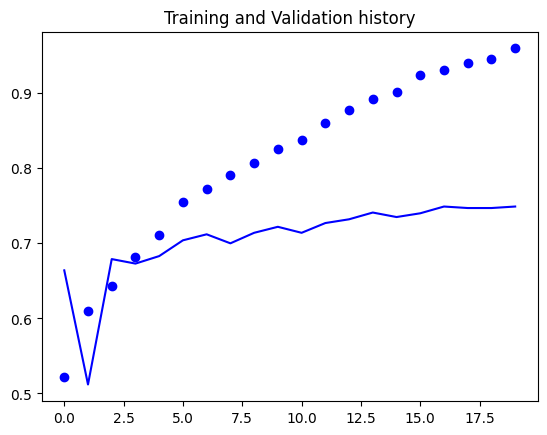

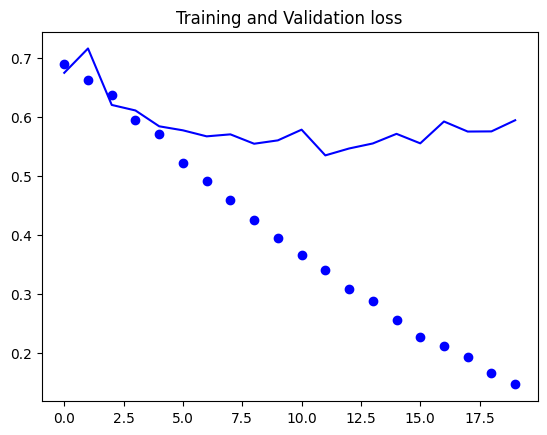

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']   # 通过history调用
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and Validation history')
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation loss')
plt.figure()

plt.show()

### 2 过拟合问题解决方案：数据增强（PIL或opencv）

##### 2.1 导入数据（PIL）
+ 图片存在data2
+ 举例：2张不同尺寸的图片，分别为（569，320，3）、（800，800，3）

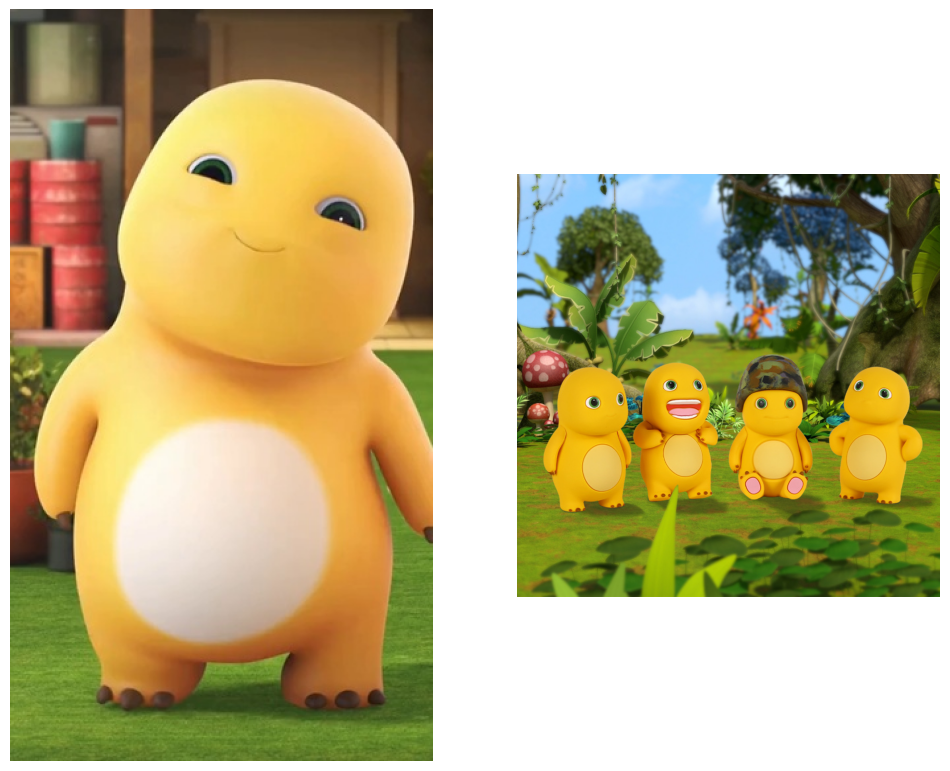

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image   # 图像库
from keras.preprocessing import image   # 加载和预处理图像
import keras.backend as K   # 使用抽象keras backend来写新代码实现兼容
import os
import glob   # 查找目录和文件
import numpy as np

# 绘制图像
def print_result(path):
    name_list = glob.glob(os.path.join(path, '*.jpg'))
    fig = plt.figure(figsize = (12, 16))
    for i in range(2):   # 2张图片
        img = Image.open(name_list[i])
        sub_img = fig.add_subplot(1, 2, i+1)   # 依次展示图片
        sub_img.axis('off')  # 去掉坐标轴
        sub_img.imshow(img)

img_path = './data2/origin'
in_path = './data2'
name_list = glob.glob(os.path.join(img_path, '*.jpg'))   # 存放文件夹中的所有文件路径（显示\\不影响，有路径就行）
print_result(img_path)

##### 2.2 将图像变成相同大小

Found 2 images belonging to 2 classes.


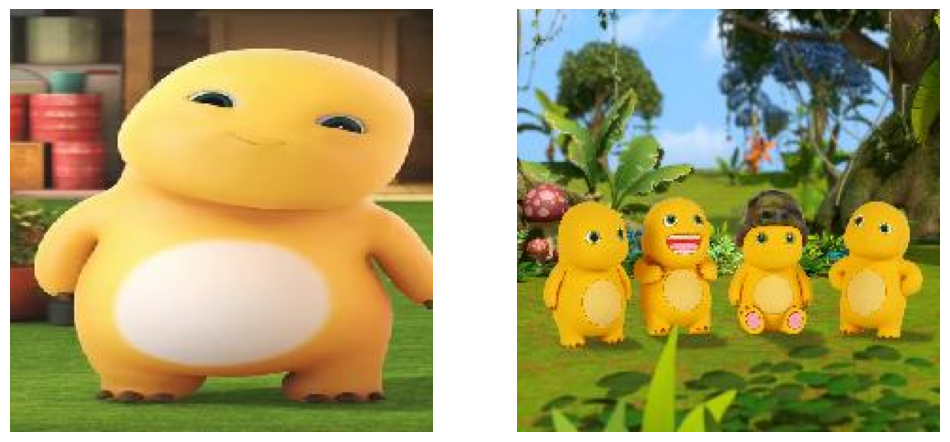

In [24]:
datagen = image.ImageDataGenerator()
gen_data = datagen.flow_from_directory(in_path, batch_size = 1, shuffle = False, save_to_dir = os.path.join(in_path, 'resize'),
                                    save_format = 'jpg', save_prefix = 'nailong', target_size = (224, 224))
for i in range(2):
    gen_data.next()   # 逐个生成图像
    
out_path = './data2'
print_result(os.path.join(out_path, 'resize/'))

### 3 猫狗识别简单实现（数据增强改进）
+ 加入数据增强后，测试集准确率和训练集准确率接近，缓解了过拟合
+ imagedatagenerator并不增加多少倍数据，而是在每次迭代时对原图片进行一次变换（旋转平移等），变换前后的总数据量相等。这样遍历20个epoch，原来的一张图片可能经过20种变换

##### 3.1 指定数据路径（训练集和验证集）
+ 同第1节

In [27]:
import os
import warnings
warnings.filterwarnings ("ignore")   # 忽略警告消息
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 数据文件夹
base_dir = './data1/'
train_dir = os.path.join(base_dir, 'train/')
validation_dir = os.path.join(base_dir, 'validation/')

# 训练集
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# 测试集
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

##### 3.2 数据预处理
+ 加入数据增强

In [30]:
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 40, width_shift_range = 0.2,
                                   height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2,
                                   horizontal_flip = True, fill_mode = 'nearest')   # 归一化图像，加入数据增强(旋转角度、宽度偏移、高度偏移、剪切角度、缩放大小、随机水平翻转、默认填充)
test_datagen = ImageDataGenerator(rescale = 1./255)   # 测试数据不进行数据预处理

train_generator = train_datagen.flow_from_directory(   # 训练生成器
    train_dir,   # 文件夹路径
    target_size = (64, 64),   # 指定resize成的大小
    batch_size = 20,   # 小批量大小
    class_mode = 'binary'   # 二分类用binary，多分类用categorical
)

validation_generator = test_datagen.flow_from_directory(   # 测试生成器
    validation_dir,   # 文件夹路径
    target_size = (64, 64),   # 指定resize成的大小
    batch_size = 20,   # 小批量大小
    class_mode = 'binary'   # 二分类用binary，多分类用categorical
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


##### 3.3 构建卷积神经网络
+ 同第1节

In [31]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (64, 64, 3)),   # 卷积，参数个数：32×3×3×3+32
    tf.keras.layers.MaxPooling2D(2, 2),   # 最大池化

    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),   # 卷积，参数个数：64×3×3×32+64
    tf.keras.layers.MaxPooling2D(2, 2),   # 最大池化

    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),   # 卷积，参数个数：128×3×3×64+128
    tf.keras.layers.MaxPooling2D(2, 2),   # 最大池化

    tf.keras.layers.Flatten(),   # 全连接准备
    tf.keras.layers.Dense(512, activation = 'relu'),   # 全连接
    tf.keras.layers.Dense(1, activation = 'sigmoid')   # 二分类（0.5划分阈值）
])

model.summary()   # 输出模型结果
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 1e-4), metrics = ['acc'])   # 配置训练器

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 128)       

##### 3.4 训练网络模型
+ 改为100次迭代

In [34]:
history = model.fit(
    train_generator,
    steps_per_epoch = 100,   # 数据量/批量大小=批次
    epochs = 100,   # 迭代次数
    validation_data = validation_generator,
    validation_steps = 50,   # 数据量/批量大小=批次
    verbose = 2
)

Epoch 1/100
100/100 - 10s - loss: 0.5529 - acc: 0.7180 - val_loss: 0.5127 - val_acc: 0.7320 - 10s/epoch - 101ms/step
Epoch 2/100
100/100 - 10s - loss: 0.5530 - acc: 0.7190 - val_loss: 0.5324 - val_acc: 0.7140 - 10s/epoch - 98ms/step
Epoch 3/100
100/100 - 9s - loss: 0.5398 - acc: 0.7310 - val_loss: 0.6704 - val_acc: 0.6350 - 9s/epoch - 92ms/step
Epoch 4/100
100/100 - 9s - loss: 0.5441 - acc: 0.7225 - val_loss: 0.5522 - val_acc: 0.6970 - 9s/epoch - 90ms/step
Epoch 5/100
100/100 - 9s - loss: 0.5530 - acc: 0.7140 - val_loss: 0.5082 - val_acc: 0.7290 - 9s/epoch - 92ms/step
Epoch 6/100
100/100 - 9s - loss: 0.5411 - acc: 0.7205 - val_loss: 0.5391 - val_acc: 0.7220 - 9s/epoch - 91ms/step
Epoch 7/100
100/100 - 9s - loss: 0.5256 - acc: 0.7405 - val_loss: 0.5350 - val_acc: 0.7220 - 9s/epoch - 91ms/step
Epoch 8/100
100/100 - 9s - loss: 0.5336 - acc: 0.7395 - val_loss: 0.5260 - val_acc: 0.7310 - 9s/epoch - 92ms/step
Epoch 9/100
100/100 - 9s - loss: 0.5289 - acc: 0.7350 - val_loss: 0.5042 - val_acc:

##### 3.5 效果展示
+ 改了曲线方式，其他不变

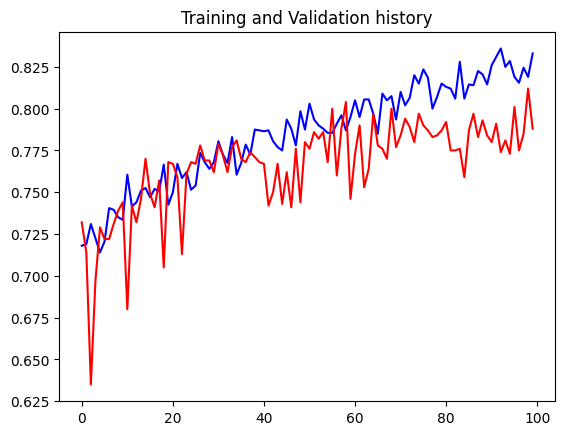

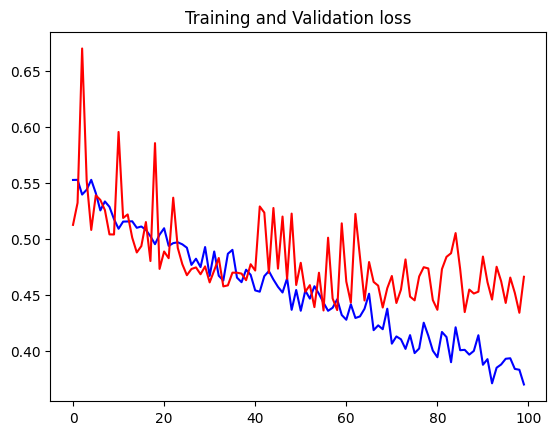

<Figure size 640x480 with 0 Axes>

In [35]:
import matplotlib.pyplot as plt

acc = history.history['acc']   # 通过history调用
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and Validation history')
plt.figure()

plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation loss')
plt.figure()

plt.show()

### 4 猫狗识别简单实现（dropout改进）
+ dropout使神经元以一定的概率随机失活，常用于全连接层（参数较多，更容易发生过拟合）
+ 这里在原先有数据增强的基础上加入dropout，结果比没有dropout差一点，需要进行调参

##### 4.1 指定数据路径（训练集和验证集）
+ 同第3节

In [3]:
import os
import warnings
warnings.filterwarnings ("ignore")   # 忽略警告消息
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 数据文件夹
base_dir = './data1/'
train_dir = os.path.join(base_dir, 'train/')
validation_dir = os.path.join(base_dir, 'validation/')

# 训练集
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# 测试集
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

##### 4.2 数据预处理
+ 同第3节

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 40, width_shift_range = 0.2,
                                   height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2,
                                   horizontal_flip = True, fill_mode = 'nearest')   # 归一化图像，加入数据增强(旋转角度、宽度偏移、高度偏移、剪切角度、缩放大小、随机水平翻转、默认填充)
test_datagen = ImageDataGenerator(rescale = 1./255)   # 测试数据不进行数据预处理

train_generator = train_datagen.flow_from_directory(   # 训练生成器
    train_dir,   # 文件夹路径
    target_size = (64, 64),   # 指定resize成的大小
    batch_size = 20,   # 小批量大小
    class_mode = 'binary'   # 二分类用binary，多分类用categorical
)

validation_generator = test_datagen.flow_from_directory(   # 测试生成器
    validation_dir,   # 文件夹路径
    target_size = (64, 64),   # 指定resize成的大小
    batch_size = 20,   # 小批量大小
    class_mode = 'binary'   # 二分类用binary，多分类用categorical
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


##### 4.3 构建卷积神经网络
+ 在全连接层中使用dropout

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (64, 64, 3)),   # 卷积，参数个数：32×3×3×3+32
    tf.keras.layers.MaxPooling2D(2, 2),   # 最大池化

    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),   # 卷积，参数个数：64×3×3×32+64
    tf.keras.layers.MaxPooling2D(2, 2),   # 最大池化

    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),   # 卷积，参数个数：128×3×3×64+128
    tf.keras.layers.MaxPooling2D(2, 2),   # 最大池化

    tf.keras.layers.Flatten(),   # 全连接准备
    tf.keras.layers.Dense(512, activation = 'relu'),   # 全连接
    tf.keras.layers.Dropout(0.5),   # 正则化防止过拟合
    tf.keras.layers.Dense(1, activation = 'sigmoid')   # 二分类（0.5划分阈值）
])

model.summary()   # 输出模型结果
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 1e-4), metrics = ['acc'])   # 配置训练器

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

##### 4.4 训练网络模型
+ 同第4节

In [7]:
history = model.fit(
    train_generator,
    steps_per_epoch = 100,   # 数据量/批量大小=批次
    epochs = 100,   # 迭代次数
    validation_data = validation_generator,
    validation_steps = 50,   # 数据量/批量大小=批次
    verbose = 2
)

Epoch 1/100
100/100 - 12s - loss: 0.6941 - acc: 0.5165 - val_loss: 0.6982 - val_acc: 0.5000 - 12s/epoch - 125ms/step
Epoch 2/100
100/100 - 12s - loss: 0.6896 - acc: 0.5340 - val_loss: 0.6779 - val_acc: 0.5470 - 12s/epoch - 118ms/step
Epoch 3/100
100/100 - 10s - loss: 0.6754 - acc: 0.5950 - val_loss: 0.6544 - val_acc: 0.6520 - 10s/epoch - 103ms/step
Epoch 4/100
100/100 - 10s - loss: 0.6716 - acc: 0.5825 - val_loss: 0.6443 - val_acc: 0.6220 - 10s/epoch - 100ms/step
Epoch 5/100
100/100 - 10s - loss: 0.6499 - acc: 0.6285 - val_loss: 0.6053 - val_acc: 0.6720 - 10s/epoch - 101ms/step
Epoch 6/100
100/100 - 10s - loss: 0.6379 - acc: 0.6305 - val_loss: 0.6196 - val_acc: 0.6400 - 10s/epoch - 99ms/step
Epoch 7/100
100/100 - 10s - loss: 0.6274 - acc: 0.6480 - val_loss: 0.5914 - val_acc: 0.6610 - 10s/epoch - 98ms/step
Epoch 8/100
100/100 - 10s - loss: 0.6228 - acc: 0.6555 - val_loss: 0.5967 - val_acc: 0.6730 - 10s/epoch - 104ms/step
Epoch 9/100
100/100 - 10s - loss: 0.6195 - acc: 0.6565 - val_loss:

##### 4.5 效果展示
+ 改了曲线方式，其他不变

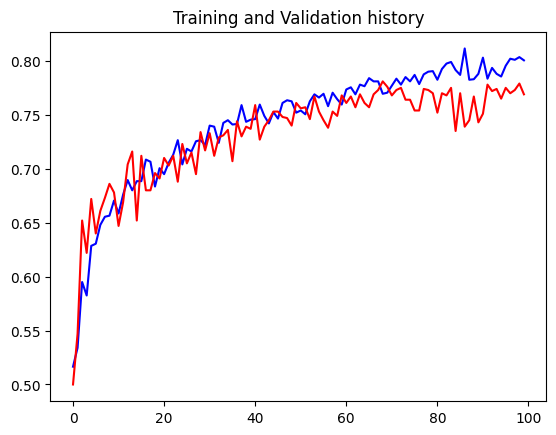

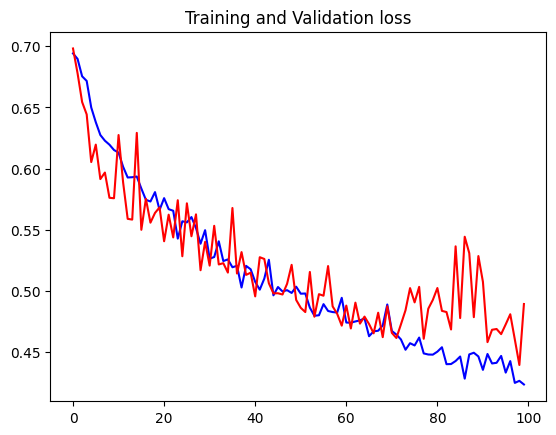

<Figure size 640x480 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']   # 通过history调用
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and Validation history')
plt.figure()

plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation loss')
plt.figure()

plt.show()